In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
from sklearn.metrics import*
import keras.activations
from keras.callbacks import EarlyStopping
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle

Using TensorFlow backend.


In [18]:
epsilon= 0.000001
learning_rate=0.001
num_epochs=55
validation_ratio=0.3
num_test=45

In [19]:
x_ee = np.load('../input/testing-data-nda/test/x_abnormal.npy')
s_ee = np.load("../input/testing-data-nda/test/s_abnormal.npy")
xx = np.load('../input/testing-data-nda/test/x_normal.npy')
ss = np.load('../input/testing-data-nda/test/s_normal.npy')
x_test = np.concatenate((x_ee, xx))
s_test = np.concatenate((s_ee, ss))

In [20]:
x_test = np.expand_dims(x_test, axis=3)
s_test = np.expand_dims(s_test, axis=1)

In [21]:
root="../input/mid-brain-images/data/data/"
x=[]
s=[]
for i in range(1, 7):
    x_temp = np.load(root+'x_train'+str(i)+'.npy')
    s_temp = np.load(root+'s_train'+str(i)+'.npy')
    x.append(x_temp); s.append(s_temp)
    

In [22]:
for i in range(1, 6):
    x[0]= np.concatenate((x[0], x[i]))
for i in range(1, 6):
    s[0]= np.concatenate((s[0], s[i]))

In [23]:
x_test, s_test = shuffle(x_test, s_test)

In [24]:
x_val, s_val = x_test[0:num_test, :, :, :], s_test[0:num_test,:]

In [25]:
x[0] = np.expand_dims(x[0], axis=3)
s[0] = np.expand_dims(s[0], axis=1)
x[0]= np.concatenate((x[0], x_val))
s[0]= np.concatenate((s[0], s_val))

In [26]:
x_train,s_train= shuffle(x[0], s[0])

In [27]:
mean= np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train-mean)/(std+epsilon)
# x_train = np.expand_dims(x_train, axis=3)
# s_train= np.expand_dims(s_train, axis=1)

In [12]:
x_test = (x_test-mean)/(std+epsilon)

In [28]:
#applying batch norm
def CNN2_model(input_shape):
    X_input = Input(input_shape)  # 180, 180, 1
    out= Conv2D(4, (9, 9),strides= (2, 2))(X_input) #86,86,4
    out= MaxPool2D(strides=(1, 1))(out) #85,85,4
    out= Activation('relu')(out) #85, 85, 4
    out= Conv2D(16, (7, 7),strides=  (2, 2))(out) #40, 40, 16
    out= MaxPool2D(strides=(1, 1))(out) #39, 39, 16
    out= Activation('relu')(out) 
    out= Conv2D(32, (5, 5), strides= (2, 2))(out) #18,18 32
    out= MaxPool2D(strides=(1, 1))(out) #17, 17, 32
    out= Activation('relu')(out) 
    out= Conv2D(64, (5, 5), activation='relu', strides=(2, 2))(out) #7, 7, 64
    out= Flatten()(out)
    out= Dense(2048, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(1024, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(512, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(64, activation='relu')(out)
    out= BatchNormalization()(out)
    out= Dense(10, activation='relu')(out)
    out= Dense(1, activation='sigmoid')(out)
    
    return Model(inputs= X_input, outputs= out)

#even more batch size:
#when trained on more epochs

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10,baseline=0.974, verbose=True)
model3= CNN2_model((180, 180, 1))
model3.compile(optimizer='Nadam',loss='binary_crossentropy',metrics=['accuracy'])
history=model3.fit(x=x_train,y=s_train, batch_size=64,epochs=55,verbose=True, validation_data=(x_test, s_test))
model3.save('saved_model3.h5')
predictions =model3.predict(x_test)
predictions= predictions>=0.5
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_curve
accuracy_score = accuracy_score(s_test, predictions)
recall_score= recall_score(s_test, predictions)
f1_score=f1_score(s_test, predictions)
from scipy.spatial.distance import dice
dice_diss_coeff = dice(s_test, predictions)
DSC= 1-dice_diss_coeff
print('num_test ='+str(num_test))
print("DSC = "+str(DSC))
print("accuracy = "+str(accuracy_score))
print('recall = '+str(recall_score))
print('f1 score = '+str(f1_score))


In [ ]:
print(x_val.shape)
print(s_val.shape)

In [15]:
predictions = model3.predict(x_val)
predictions = predictions>0.5
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_curve, precision_score
precision_score= precision_score(s_val, predictions)
accuracy_score = accuracy_score(s_val, predictions)
recall_score= recall_score(s_val, predictions)
f1_score=f1_score(s_val, predictions)
from scipy.spatial.distance import dice
dice_diss_coeff = dice(s_val, predictions)
DSC= 1-dice_diss_coeff
print("DSC = "+str(DSC))
print("accuracy = "+str(accuracy_score))
print('recall = '+str(recall_score))
print('f1 score = '+str(f1_score))
print('precision score = '+str(precision_score))

DSC = 0.4629629629629629
accuracy = 0.35555555555555557
recall = 0.7142857142857143
f1 score = 0.46296296296296297
precision score = 0.3424657534246575


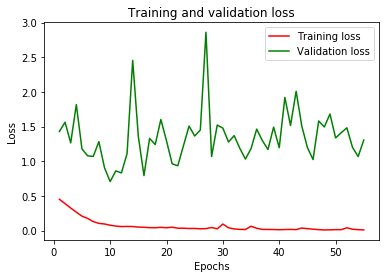

In [16]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

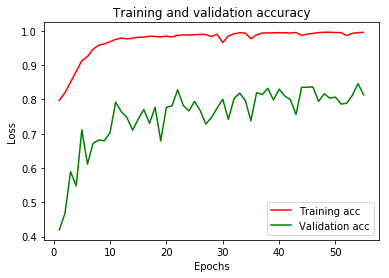

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()